## Case study

- Author: Alejandro Notario
- Date: 2019-11-07

## Steps:

- Data clean up
- Feature engineering
- Modelling
- Evaluation

__Required libraries__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

## Data clean up

- Exploring data
- Setting up the target
- Imputation
- Handling ouliers. Percentiles. Dropping

__Load the dataframe__

In [2]:
df=pd.read_csv('casestudy_data.csv', sep =',', low_memory=False)

__Exploring__

In [3]:
#dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
policy_desc                   678013 non-null int64
claim_count                   678013 non-null int64
cat_areacode                  678013 non-null object
num_vehicleAge                678013 non-null int64
num_noClaimDiscountPercent    678013 non-null int64
cat_carBrand                  678013 non-null object
num_populationDensitykmsq     678013 non-null int64
cat_Region                    678013 non-null object
ord_vehicleHP                 678013 non-null int64
num_exposure                  678013 non-null object
cat_fuelType                  677991 non-null object
num_driverAge                 677999 non-null object
dtypes: int64(6), object(6)
memory usage: 62.1+ MB


__Target__

Exploring the target to decide how is going to be worked

In [4]:
#checking if there are duplicates ids
df.policy_desc.nunique()

678013

In [5]:
df.claim_count.value_counts()

0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
16         1
9          1
8          1
6          1
Name: claim_count, dtype: int64

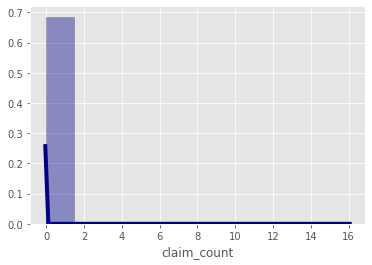

In [6]:
sns.distplot(df['claim_count'],  kde=True, 
             bins=int(11), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

__The target has their main values between 0 an 1 claim so it is going to be set up 3 categories:__

- 0 -> 0 claims
- 1 -> 1 claim
- 2 -> >= 2 claims

__Recoding__

In [7]:
def recode(row):
    if row['claim_count'] >= 2: 
        val = 2
    else:
        val=row['claim_count']
        
    return val

df['target'] = df.apply (recode, axis=1)

As it can be seen above, num_exposure, which is a numerical variable, has an object type, lets see what happens:

- Creating a new only numeric variable
- Checking the rows that they are not in the new column

__Exposure time__

Check the range, to predict claims / time unit. It is not possible to know how long it is going to stay a custumer at the company, so the target is going to be claims/time unit
I work supposing the float (0.002732-2.010000 as below) is a year fraction

In [8]:
df['num_exposure_num'] = pd.to_numeric(df['num_exposure'], errors='coerce')
#those rows with no numerical value are recoded as null, lets see several calues distributions
print(df.num_exposure_num.describe())
print(df[df['num_exposure_num'].isnull()].claim_count.value_counts())
print(df[df['num_exposure_num'].isnull()].num_exposure.value_counts())
print(df[df['num_exposure_num'].isnull()].num_exposure.count())

count    677942.000000
mean          0.528750
std           0.364441
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: num_exposure_num, dtype: float64
0    66
1     4
2     1
Name: claim_count, dtype: int64
37years    27
23years    27
10years    17
Name: num_exposure, dtype: int64
71


It seems it is either another variable or these values are from another customer cluster or whatever. To train this model, as p75 is around 1 year policy exposure and they are 71 rows out of 678013, they are going to be dropped

In [9]:
#Dropping
df = df[~df['num_exposure_num'].isnull()]

In [10]:
df[df['num_exposure_num']==1].num_exposure_num.describe()

count    168107.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: num_exposure_num, dtype: float64

__Method 1__

There are many different exposure times, and it is not easy to decide a criteria to include or not every customer. A customer with only a few days of exposure does not represent the same...in fact the perfect prediction could be using only customers with the same exposure time.
Thus, in this method I have selected customers with one year period, so the prediction is the claims count for the first year of a customer, it makes more sense than the first method, it is "probability of number of claims for this customer whithin their first policy year"

__Secleting policies by period__

In [11]:
print("the dataframe which 1 year preriod customers has : \n")
df=df[df['num_exposure_num']==1]
print(df.shape[0], "customers")

the dataframe which 1 year preriod customers has : 

168107 customers


In [12]:
df.head()

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge,target,num_exposure_num
5051,16642,1,B,7,50,B1,67,R24,8,1,Diesel,55,1,1.0
5052,16644,1,B,10,50,B2,91,R24,4,1,Regular,71,1,1.0
5054,16648,1,A,25,50,B2,18,R24,7,1,Regular,87,1,1.0
5055,16650,1,C,9,50,B6,272,R72,8,1,Diesel,56,1,1.0
5056,16652,1,A,10,50,B2,10,R24,4,1,Regular,63,1,1.0


In [13]:
df.target.value_counts()

0    156897
1     10674
2       536
Name: target, dtype: int64

New dataframe info

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168107 entries, 5051 to 623137
Data columns (total 14 columns):
policy_desc                   168107 non-null int64
claim_count                   168107 non-null int64
cat_areacode                  168107 non-null object
num_vehicleAge                168107 non-null int64
num_noClaimDiscountPercent    168107 non-null int64
cat_carBrand                  168107 non-null object
num_populationDensitykmsq     168107 non-null int64
cat_Region                    168107 non-null object
ord_vehicleHP                 168107 non-null int64
num_exposure                  168107 non-null object
cat_fuelType                  168104 non-null object
num_driverAge                 168104 non-null object
target                        168107 non-null int64
num_exposure_num              168107 non-null float64
dtypes: float64(1), int64(7), object(6)
memory usage: 19.2+ MB


There are nulls at cat_fuelType and num_driverAge

- To analyze their distribution
- To decide if drop ot make an imputation

In [15]:
print("nulls: ", df.cat_fuelType.isnull().sum())
print(df.cat_fuelType.value_counts(), df.cat_fuelType.describe())
print("nulls: ", df.num_driverAge.isnull().sum())
print(df.num_driverAge.describe())

nulls:  3
Regular     91670
Diesel      76429
Electric        5
Name: cat_fuelType, dtype: int64 count      168104
unique          3
top       Regular
freq        91670
Name: cat_fuelType, dtype: object
nulls:  3
count     168104
unique        83
top           51
freq        4739
Name: num_driverAge, dtype: object


Null are going to be filled by the top value at cat_fuelType and by the median at num_driverAge

In [16]:
df.num_driverAge.isnull().sum()

3

In [17]:
#transform to numeric
df['num_driverAge_num'] = pd.to_numeric(df['num_driverAge'], errors='coerce')

There are blank rows at num_driverAge and this is a problem to work with the column data

In [18]:
df[df['num_driverAge_num'].isnull()].head()

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge,target,num_exposure_num,num_driverAge_num
105969,1032478,0,C,12,68,B6,238,R54,8,1,Diesel,,0,1.0,NaN
109314,1039799,0,C,1,50,B2,369,R73,8,1,Regular,NaN,0,1.0,NaN
387366,3054494,0,C,9,50,B1,295,R24,8,1,Diesel,NaN,0,1.0,NaN
436711,3158719,0,B,4,50,B3,56,R73,7,1,Diesel,,0,1.0,NaN
530452,4121630,0,D,10,50,B11,564,R11,7,1,Regular,,0,1.0,NaN


Let's check if there are similar issues in the rest of columns

In [19]:
#it seems there are not any blanks at the others 
df.replace(r'^\s*$', np.nan, regex=True).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168107 entries, 5051 to 623137
Data columns (total 15 columns):
policy_desc                   168107 non-null int64
claim_count                   168107 non-null int64
cat_areacode                  168107 non-null object
num_vehicleAge                168107 non-null int64
num_noClaimDiscountPercent    168107 non-null int64
cat_carBrand                  168107 non-null object
num_populationDensitykmsq     168107 non-null int64
cat_Region                    168107 non-null object
ord_vehicleHP                 168107 non-null int64
num_exposure                  168107 non-null object
cat_fuelType                  168104 non-null object
num_driverAge                 168100 non-null object
target                        168107 non-null int64
num_exposure_num              168107 non-null float64
num_driverAge_num             168100 non-null float64
dtypes: float64(2), int64(7), object(6)
memory usage: 20.5+ MB


Replacing nans with column median

In [20]:
df.num_driverAge_num.median()

49.0

In [21]:
df.num_driverAge_num=df.num_driverAge_num.fillna(df.num_driverAge_num.median())

Filling cat_fuelType with the column top value

In [22]:
df.cat_fuelType=df.cat_fuelType.fillna("Regular")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168107 entries, 5051 to 623137
Data columns (total 15 columns):
policy_desc                   168107 non-null int64
claim_count                   168107 non-null int64
cat_areacode                  168107 non-null object
num_vehicleAge                168107 non-null int64
num_noClaimDiscountPercent    168107 non-null int64
cat_carBrand                  168107 non-null object
num_populationDensitykmsq     168107 non-null int64
cat_Region                    168107 non-null object
ord_vehicleHP                 168107 non-null int64
num_exposure                  168107 non-null object
cat_fuelType                  168107 non-null object
num_driverAge                 168104 non-null object
target                        168107 non-null int64
num_exposure_num              168107 non-null float64
num_driverAge_num             168107 non-null float64
dtypes: float64(2), int64(7), object(6)
memory usage: 20.5+ MB


Explore distributions to check otliers at numeric columns

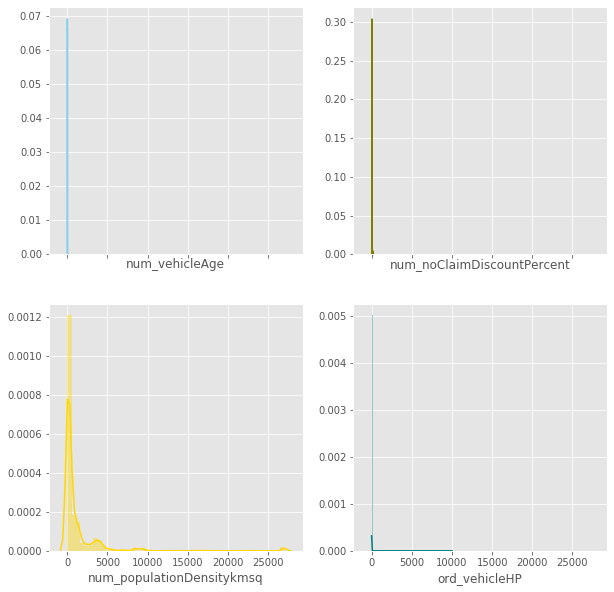

In [24]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.distplot( df["num_vehicleAge"] , color="skyblue", ax=axes[0, 0])
sns.distplot( df["num_noClaimDiscountPercent"] , color="olive", ax=axes[0, 1])
sns.distplot( df["num_populationDensitykmsq"] , color="gold", ax=axes[1, 0])
sns.distplot( df["ord_vehicleHP"] , color="teal", ax=axes[1, 1])

Tehre is something strange at ord_vehicleHP, let's see

In [25]:
df.ord_vehicleHP.value_counts()

6       42473
7       37585
5       34167
4       27419
8        8705
9        6621
10       5631
11       2774
12       1166
13        728
14        494
15        329
9999        7
1111        5
999         3
Name: ord_vehicleHP, dtype: int64

ord_vehicle values of 9999, 1111, 999? suppossing they are mistakes labeling or so on, to keep the ordinal sense (the other option is one hot encoding) lets recode to 16, 17, 18 in the frequency descendent order as from 4 to 15 there are decreasing each step

In [26]:
def recode(row):
    if row['ord_vehicleHP'] == 1111:
        val = 16
    elif row['ord_vehicleHP'] == 9999:
        val = 17
    elif row['ord_vehicleHP'] == 999:
        val = 18
    else:
        val=row['ord_vehicleHP']
    return val

df['ord_vehicleHP'] = df.apply (recode, axis=1)

Maybe it would not good to drop outliers based on percentiles or so because the other variables as population density, discount, vehicle ages...are inmutable characteristics of the customers

## Feature engineering

- Scaling 
- Encoding
- New variables

__Standard scaling__

It is good practice using SVM and KNN to scale because they are algorithms that exploit distances.
There are several ways to do it. In this case it has been selected the standard scaling from the SciKit Learn library

In [27]:
#variables to transform: 
col_names = ['num_vehicleAge', 'num_noClaimDiscountPercent','num_populationDensitykmsq',
            'num_driverAge_num','num_exposure_num']
#make a copy of dataframe before scale
scaled_df = df.copy()

features = scaled_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_df[col_names] = features

__Selecting/dropping columns__

In this method it does not make sense to include the time period

In [28]:
#'num_exposure_num' extracted
scaled_df=scaled_df[['policy_desc','cat_areacode','num_vehicleAge','num_noClaimDiscountPercent',
                    'cat_carBrand','num_populationDensitykmsq','cat_Region','ord_vehicleHP','cat_fuelType',
                    'num_driverAge_num','target']].copy()

Creating dummies. Tehere are categorical varibles and one ordinal variable which are going to be encoded as a binary variables.

In [29]:
#new dataframe with binary dummies
enc_df=scaled_df.copy()
enc_df=pd.get_dummies(enc_df, columns=['cat_areacode', 'cat_carBrand','cat_Region',
            'ord_vehicleHP','cat_fuelType'])

In [30]:
enc_df.sample(2)

,policy_desc,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,num_driverAge_num,target,cat_areacode_A,cat_areacode_B,cat_areacode_C,cat_areacode_D,...,ord_vehicleHP_12,ord_vehicleHP_13,ord_vehicleHP_14,ord_vehicleHP_15,ord_vehicleHP_16,ord_vehicleHP_17,ord_vehicleHP_18,cat_fuelType_Diesel,cat_fuelType_Electric,cat_fuelType_Regular
527084,4118262,1.151054,-0.424969,-0.384451,-0.471166,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
557782,4148960,-1.448209,-0.424969,-0.383819,1.301994,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


__Check correlation between variables__

It is necessary to know if there are string correlated features because they can inlfuence in the predictions making overfitting or another issues.
It seems there are very few hard correlations based on Pearson coeficient, so it is not going to be extracted any variable

In [31]:
#https://www.displayr.com/what-is-a-correlation-matrix/
corr = enc_df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

## Modelling

Method: It has been selected KNN algorithm 

__Nearest Neighbors Algorithm__

Documentation about this method:

- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm



__Splitting data__

In [32]:
#splittin 75%/25% train-test
training_set, test_set = train_test_split(enc_df, test_size = 0.25, random_state = 42,
                                          stratify=enc_df['target'])

In [33]:
X_train = training_set.drop('target', axis=1).values
Y_train = training_set['target'].values
X_test = test_set.drop('target', axis=1).values
Y_test = test_set['target'].values


__Tunning hyperparameters__

- K: number of neighbors based on RMSE, seleted checking results below
- Algorithm: 'auto'. will attempt to decide the most appropriate algorithm based on the values passed to fit method
- weights ('uniform'/default)
- leaf_size(30/default)
- p(2/default) Minkowski distance metric with value of p as 2 KNN classifier is going to use Euclidean Distance Metric formula
- metric('minkowski'/default)
- metric_params, n_jobs

In [34]:
%%time

#let's see accuracies from 1 to 8 neighbors
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    #Fit the model
    classifier.fit(X_train, Y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = classifier.score(X_train, Y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = classifier.score(X_test, Y_test) 


CPU times: user 1min 7s, sys: 228 ms, total: 1min 7s
Wall time: 1min 6s


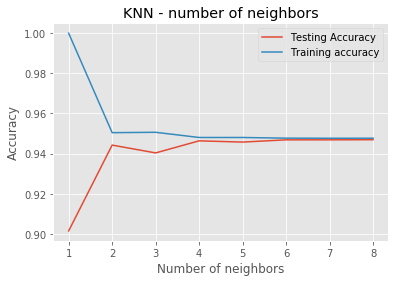

In [35]:
plt.title('KNN - number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

__Optimum testing accuracy at 4 neightbors__



In [36]:
%%time

classifier=KNeighborsClassifier(n_neighbors = 4, algorithm='auto')
classifier.fit(X_train,Y_train)

CPU times: user 860 ms, sys: 7.88 ms, total: 868 ms
Wall time: 866 ms


## Evaluation

In [37]:
%%time

Y_pred = classifier.predict(X_test)

CPU times: user 2 s, sys: 113 µs, total: 2 s
Wall time: 1.98 s


In [38]:
test_set["Predictions"] = Y_pred

In [39]:
test_set.Predictions.value_counts()

0    41383
1      644
Name: Predictions, dtype: int64

In [40]:
cm = confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix")
print("****************")
print(cm)

Confusion Matrix
****************
[[39194    30     0]
 [ 2090   579     0]
 [   99    35     0]]


In [41]:
accuracy = float(cm.diagonal().sum())/len(Y_test)

In [42]:
print("\nAccuracy Of KNN : ", accuracy)


Accuracy Of KNN :  0.9463678111690104


__Total dataset prediction (simulating as it were a real performance)__

In [43]:
X = enc_df.drop('target', axis=1).values
Y = enc_df['target'].values

In [44]:
%%time

predictions = classifier.predict(X)

CPU times: user 7.13 s, sys: 3.78 ms, total: 7.13 s
Wall time: 7.12 s


In [45]:
enc_df["Predictions"] = predictions

__Simulation game__

In [47]:
policy_id=input("Please input the policy identifier: ")
policy_id=int(policy_id)
print('**************************************')
def check_results():
    """Function that returns the number of claims predicted
    and if this prediction is right
    """
    target_value=enc_df[enc_df['policy_desc']==policy_id].target.values
    prediction_value=enc_df[enc_df['policy_desc']==policy_id].Predictions.values
    
    if target_value==prediction_value:
        print("I say the claims for the policy {}".format(policy_id),
              "are goint to be in group {}".format(prediction_value), 
             "and this is a correct prediction!")
    else:
         print("I say the claims for the policy {}".format(policy_id),
              "are goint to be {}".format(prediction_value), 
             "but...oops...this is wrong, they will be in group {}".format(target_value))
    
    print ("\nGroups description: \n")
    print ("Group 0 -> 0 claims its first year")
    print ("Group 1 -> 1 claims its first year")
    print ("Group 2 -> 2 or more claims its first year")
    
def main():
    check_results()

if __name__=='__main__':
    main()

Please input the policy identifier: 16642
**************************************
I say the claims for the policy 16642 are goint to be in group [1] and this is a correct prediction!

Groups description: 

Group 0 -> 0 claims its first year
Group 1 -> 1 claims its first year
Group 2 -> 2 or more claims its first year
